# Lending Club Data Set Prediction

In [875]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from numpy.random import seed
from scipy.stats import norm
from scipy.stats import ttest_ind_from_stats
df= pd.read_csv('/Users/ankit/Desktop/Springboard dox/Python/2018_less.csv',low_memory=False)


# Understanding the various features (columns) of the dataset


In [876]:
print(df.info())
df.head()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Columns: 150 entries, id to settlement_term
dtypes: float64(63), int64(57), object(30)
memory usage: 11.4+ MB
None


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

In [877]:
print(df.shape)

(9998, 150)


In [878]:
#Drop columns with data NaN

In [879]:
#df=df.dropna(axis=1)

In [880]:
#df.shape

In [881]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,145217616,NaN,10000,10000,10000,36 months,10.33%,324.23,B,B1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,145248657,NaN,4000,4000,4000,36 months,23.4%,155.68,E,E1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,145638579,NaN,5000,5000,5000,36 months,17.97%,180.69,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,145592722,NaN,23000,23000,23000,60 months,20.89%,620.81,D,D4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,144858623,NaN,8000,8000,8000,36 months,23.4%,311.35,E,E1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


# Data Wrangling

In [882]:
#rename the column names

df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})


In [883]:
df.head()
print(type(df['interest_rate'][0]))

<class 'str'>


In [884]:
#removing percentage sign from the interest_rate
df.interest_rate = df.interest_rate.str.replace('%', '').astype('float64')
print(df.interest_rate.head())

0    10.33
1    23.40
2    17.97
3    20.89
4    23.40
Name: interest_rate, dtype: float64


In [885]:
#remove months from term colums
df.term = df.term.str.replace('months', '')
df.term.head()

0    36 
1    36 
2    36 
3    60 
4    36 
Name: term, dtype: object

In [886]:
#selecting unique column as index

df['id'].is_unique

True

In [887]:
df.set_index('id')
df.drop(['member_id'],axis=1,inplace=True)

In [888]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)
missing_fractions.head(20)

hardship_loan_status                          1.0000
hardship_dpd                                  1.0000
hardship_reason                               1.0000
hardship_status                               1.0000
deferral_term                                 1.0000
hardship_amount                               1.0000
hardship_start_date                           1.0000
hardship_end_date                             1.0000
payment_plan_start_date                       1.0000
hardship_length                               1.0000
hardship_type                                 1.0000
desc                                          1.0000
orig_projected_additional_accrued_interest    1.0000
hardship_payoff_balance_amount                1.0000
hardship_last_payment_amount                  1.0000
settlement_percentage                         0.9998
debt_settlement_flag_date                     0.9998
settlement_status                             0.9998
settlement_date                               

Text(0, 0.5, 'Feature count')

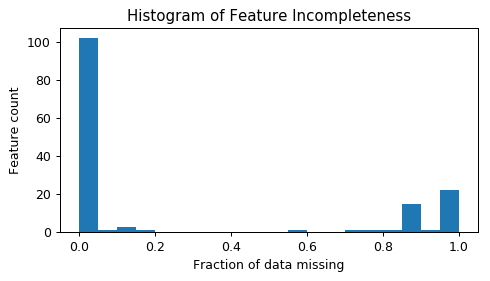

In [889]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (<20%) and those missing "lots" of data (>40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [890]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(len(drop_list))
df.drop(labels=drop_list, axis=1, inplace=True)
df.shape

42


(9998, 107)

So now we dropped 42 columns with more than 30% missing values.

In [891]:
print(df.columns)
df.info()

Index(['id', 'loan_amount', 'funded_amount', 'investor_funds', 'term',
       'interest_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       ...
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag'],
      dtype='object', length=107)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Columns: 107 entries, id to debt_settlement_flag
dtypes: float64(26), int64(57), object(24)
memory usage: 8.2+ MB


In [892]:
df['emp_title'].describe()



count        8429
unique       5277
top       Teacher
freq          196
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.




In [893]:
df.drop(labels='emp_title', axis=1, inplace=True)

In [894]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        723
10+ years    2924
2 years       933
3 years       799
4 years       562
5 years       625
6 years       436
7 years       374
8 years       312
9 years       229
< 1 year     1272
NaN           809
Name: emp_length, dtype: int64

In [895]:
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [896]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
df['emp_length'] = df['emp_length'].apply(emp_length_to_int)
df['emp_length'].value_counts(dropna=False).sort_index()

0.0     1272
1.0      723
2.0      933
3.0      799
4.0      562
5.0      625
6.0      436
7.0      374
8.0      312
9.0      229
10.0    2924
NaN      809
Name: emp_length, dtype: int64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.


In [897]:

df['log_annual_inc'] = df['annual_income'].apply(lambda x: np.log10(x+1))
df['log_annual_inc'].describe()

count    9998.000000
mean        4.844006
std         0.333509
min         0.000000
25%         4.698979
50%         4.845104
75%         5.004326
max         6.709188
Name: log_annual_inc, dtype: float64

In [898]:
df.corr()

,id,loan_amount,funded_amount,investor_funds,interest_rate,installment,emp_length,annual_income,dti,delinq_2yrs,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,log_annual_inc
id,1.000000,-0.053255,-0.053255,-0.053172,-0.024565,-0.045424,-0.010020,0.016291,-0.020629,-0.019739,...,0.018364,0.019719,0.011041,-0.013439,NaN,-0.003341,0.007374,0.006500,0.011913,0.019530
loan_amount,-0.053255,1.000000,1.000000,0.999996,-0.040163,0.940634,0.029752,0.279051,0.058237,-0.009645,...,-0.037049,0.100709,0.040991,-0.063515,NaN,0.310804,0.263456,0.353893,0.216015,0.315290
funded_amount,-0.053255,1.000000,1.000000,0.999996,-0.040163,0.940634,0.029752,0.279051,0.058237,-0.009645,...,-0.037049,0.100709,0.040991,-0.063515,NaN,0.310804,0.263456,0.353893,0.216015,0.315290
investor_funds,-0.053172,0.999996,0.999996,1.000000,-0.040058,0.940625,0.029802,0.279035,0.058271,-0.009634,...,-0.037066,0.100713,0.040984,-0.063482,NaN,0.310794,0.263450,0.353874,0.216002,0.315276
interest_rate,-0.024565,-0.040163,-0.040163,-0.040058,1.000000,0.002075,0.015889,-0.080118,0.122278,0.099538,...,0.087689,-0.129322,0.258509,0.034974,NaN,-0.112401,-0.001296,-0.239341,0.003381,-0.098201
installment,-0.045424,0.940634,0.940634,0.940625,0.002075,1.000000,0.006031,0.273672,0.061349,0.005219,...,-0.027931,0.075698,0.070220,-0.056536,NaN,0.271300,0.247227,0.325415,0.200835,0.297136
emp_length,-0.010020,0.029752,0.029752,0.029802,0.015889,0.006031,1.000000,0.037693,0.040492,0.027765,...,0.032544,-0.017606,0.015126,0.026772,NaN,0.103470,0.005795,0.037550,0.014692,0.087625
annual_income,0.016291,0.279051,0.279051,0.279035,-0.080118,0.273672,0.037693,1.000000,-0.149904,0.044302,...,0.048043,0.003586,0.056531,-0.033063,NaN,0.416748,0.351082,0.290336,0.297251,0.577478
dti,-0.020629,0.058237,0.058237,0.058271,0.122278,0.061349,0.040492,-0.149904,1.000000,-0.008190,...,0.031953,0.077234,0.123717,-0.014346,NaN,0.088116,0.221114,0.057988,0.260959,-0.260071
delinq_2yrs,-0.019739,-0.009645,-0.009645,-0.009634,0.099538,0.005219,0.027765,0.044302,-0.008190,1.000000,...,-0.041907,-0.394124,0.032892,-0.051795,NaN,0.058278,0.019925,-0.060779,0.040840,0.051673


In [899]:
df["loan_status"].value_counts()


Current               8666
Fully Paid             980
Late (31-120 days)     169
Charged Off             98
In Grace Period         65
Late (16-30 days)       19
Default                  1
Name: loan_status, dtype: int64

In [900]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

# Pie Chart for Loan Conditions

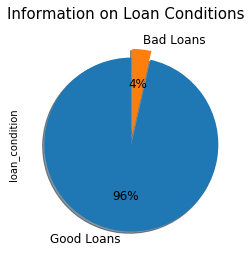

In [901]:
#f, ax = plt.subplots(1,2, figsize=(16,8))

labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=15)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.10],autopct='%1.0f%%', shadow=True,labels=labels, fontsize=12, startangle=90)




In [902]:
df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

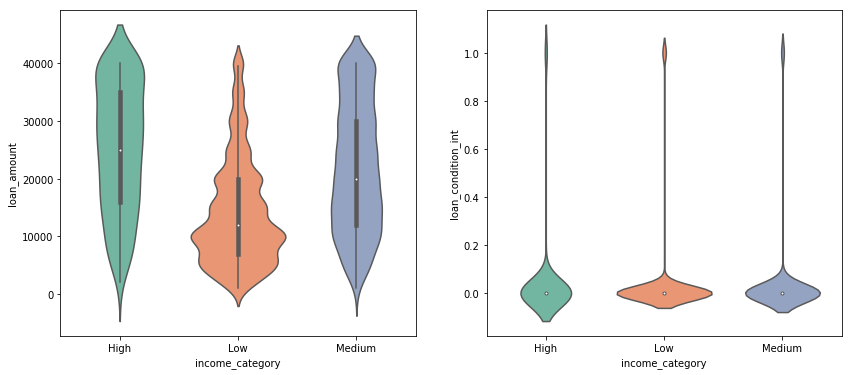

In [903]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_condition_int'] = df['loan_condition_int'].astype(int)
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, palette="Set2", ax=ax2)


In [ ]:
#df.corr(loan_status,annual_income)

# Loan Condition V/s Income

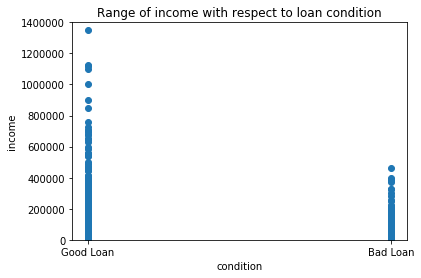

In [904]:
plt.scatter(df.loan_condition,df.annual_income)
plt.xlabel("condition")
plt.ylabel("income")
plt.ylim(0,1400000)
plt.title("Range of income with respect to loan condition")
plt.show()

# Loan Consition V/s Fico Scores

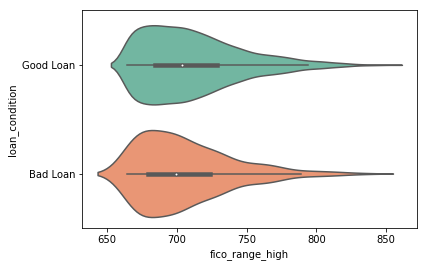

In [905]:
sns.violinplot(x="fico_range_high", y="loan_condition", data=df, palette="Set2" )
plt.show()

The mean of the good loans is more than 700 and most of the values of fico_score lies near 700 score hence the fico score for good loans should be closer to 700.

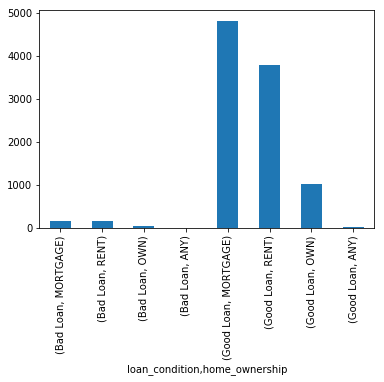

In [906]:
df.home_ownership.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Loan Grades and Subgrades are assigned by Lending Club based on the borrower’s credit worthiness and also on some variables specific to that Loan.

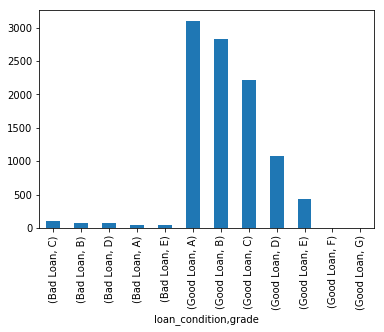

In [907]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

The majority of loans is either graded as B or C — together these correspond to more than 50% of the loan population.
While there is a considerable amount of A graded or “prime” loans (~17%), there is a small amount of E graded, or “uncollectible” loans (~0,06%). Which is a good sign for Lending Club.
But, are these the right grades?

# Statistical Inferences of the Dataset

Text(0.5, 1.0, 'Total committed by Investors')

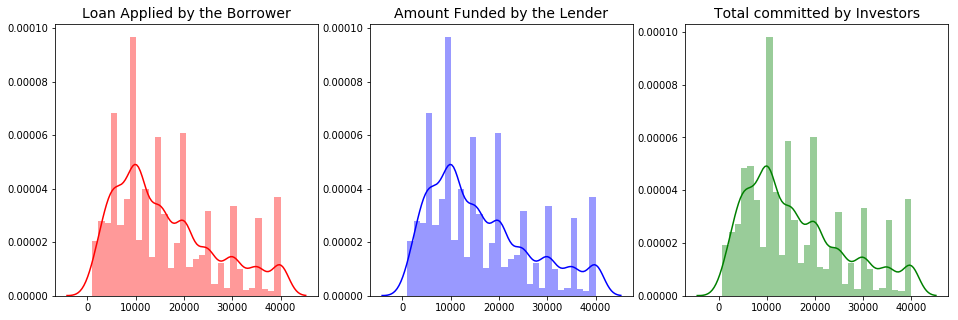

In [908]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values
sns.distplot(loan_amount, ax=ax[0], color="red")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="blue")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="green")
ax[2].set_title("Total committed by Investors", fontsize=14)

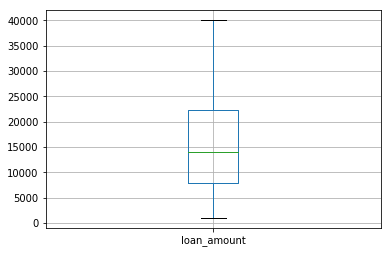

In [909]:
df.boxplot(column='loan_amount')


In [910]:
mean =np.mean(df.funded_amount)
std =np.std(df.funded_amount)
print(mean)
print(std)

16162.387477495498
10364.294412830544


# Null hypothesis: The mean interest rates offered for A grade loans are less than the other grades.

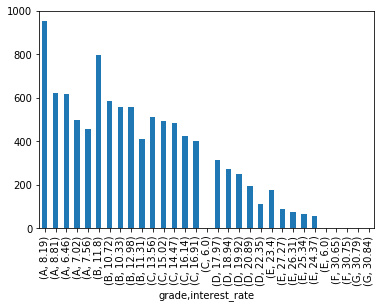

In [911]:
df.interest_rate.groupby(df.grade).value_counts().plot.bar()
plt.show()


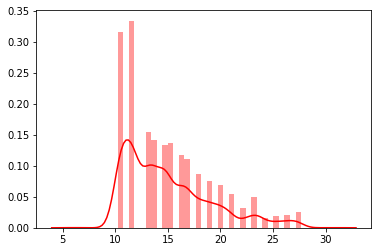

In [912]:
sns.distplot(df.interest_rate[df.grade!='A'].astype('float64').values,color="red")


In [913]:
def loan_sampler_A(n):
    return np.random.choice(df.interest_rate[df.grade=='A'].astype('float64'), n)
def loan_sampler_other(n):
    return np.random.choice(df.interest_rate[df.grade!='A'].astype('float64'),n)

In [914]:
seed(47)
size=50
sample1 = loan_sampler_A(size).astype('float64')
sample2 = loan_sampler_other(size).astype('float64')
print(sample1)
type(sample1[0])

[8.19 7.56 8.19 8.19 8.19 7.02 8.81 8.19 7.02 7.56 7.02 7.02 8.81 7.02
 6.46 6.46 8.19 8.19 8.19 6.46 8.81 6.46 7.02 8.81 6.46 6.46 7.56 8.81
 6.46 8.19 8.81 6.46 8.19 6.46 7.56 8.19 7.56 6.46 8.19 8.19 8.19 6.46
 6.46 8.19 8.81 7.56 8.81 8.19 8.81 8.81]


numpy.float64

In [915]:
mean_A = np.mean(sample1)
mean_other = np.mean(sample2)
std_A=np.std(sample1)
std_other=np.std(sample2)
seed(47)
N=500
# take your samples here
total_mean_A=np.empty(N)
total_mean_other=np.empty(N)
for i in range (N):
    total_mean_A[i]=np.mean(loan_sampler_A(size))
    total_mean_other[i]=np.mean(loan_sampler_other(size))


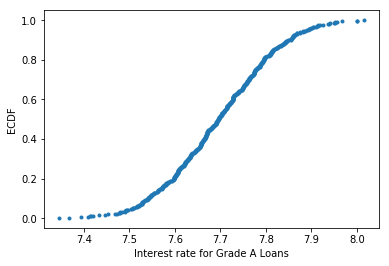

In [916]:
n=len(total_mean_A)
x=np.sort(total_mean_A)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Grade A Loans')
plt.ylabel('ECDF')
plt.show()

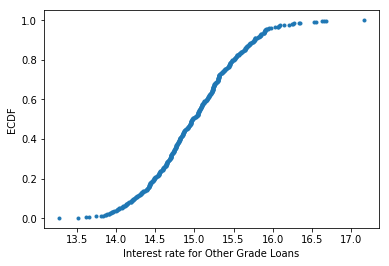

In [917]:
n=len(total_mean_other)
x=np.sort(total_mean_other)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Other Grade Loans')
plt.ylabel('ECDF')
plt.show()

It is very much clear from the above ECDF graph that the interest rates for the other grades lies in the range of (13.5,17)

In [918]:
from scipy import stats
import scipy.stats
print(stats.ttest_ind(total_mean_other,total_mean_A))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
print("The confidence interval for A grade loans is: "+str(mean_confidence_interval(total_mean_A)))
print("The confidence interval for all other loan other than A grade loans is:"+ str(mean_confidence_interval(total_mean_other)))
           
      

Ttest_indResult(statistic=272.7868617604524, pvalue=0.0)
The confidence interval for A grade loans is: (7.6957716, 7.685429813629246, 7.706113386370753)
The confidence interval for all other loan other than A grade loans is:(15.0010152, 14.949426034172765, 15.052604365827234)


Here, the p value is less than 0.05 hence the result is of high significance.

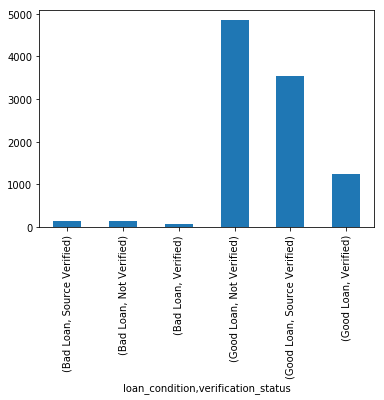

In [919]:
df.verification_status.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()


The observation is quite unexpected as it was expected that people with verified status should have less charged off loans but it is the opposit. Hence,verification status does not give any clear idea of the impact on the loan condition. So we try to see in other way.


In [920]:
pd.crosstab(df ['verification_status'], df ['loan_condition'], margins=True)


loan_condition,Bad Loan,Good Loan,All
verification_status,,,
Not Verified,136,4854,4990
Source Verified,153,3535,3688
Verified,63,1257,1320
All,352,9646,9998


This shows that 38.6% of the bad loans were not verified.

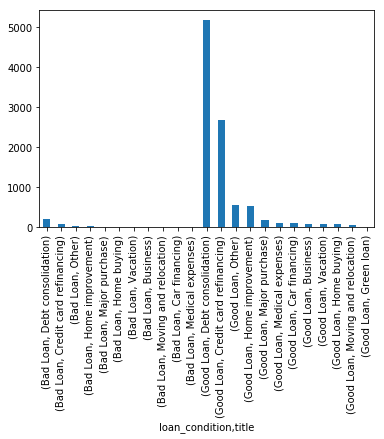

In [921]:
df.title.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

In [922]:
df[['fico_range_low', 'fico_range_high']].describe()


,fico_range_low,fico_range_high
count,9998.000000,9998.000000
mean,707.016903,711.017003
std,35.289574,35.289966
min,660.000000,664.000000
25%,680.000000,684.000000
50%,700.000000,704.000000
75%,725.000000,729.000000
max,845.000000,850.000000


Most of the good loans are being observed for the purpose of debt consolidation and credit card refinance category which can be considered as a safe category

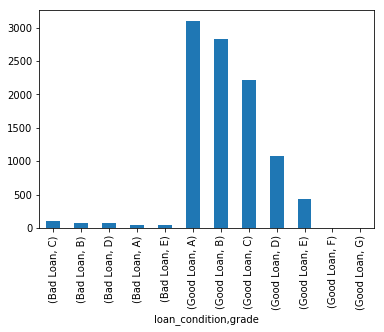

In [923]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Number of bad loans were less in the category A jobs and it had more number of good loans as compared to the other category.

# Correlation among the features

Few important columns are selected from the full dataset based on the significance and the data present prior to the approval of the loan. The columns are saved in 'imp_columns' list.

Now we will see the correlation between the numerical data

In [926]:
imp_columns=['loan_amount','term','interest_rate','grade','emp_length','home_ownership','annual_income','verification_status','loan_status','loan_condition','purpose','title','addr_state','fico_range_low','fico_range_high','avg_cur_bal','income_category']
df2=df[imp_columns]
df2.corr()

,loan_amount,interest_rate,emp_length,annual_income,fico_range_low,fico_range_high,avg_cur_bal
loan_amount,1.000000,-0.040163,0.029752,0.279051,0.093668,0.093668,0.200978
interest_rate,-0.040163,1.000000,0.015889,-0.080118,-0.373936,-0.373935,-0.058672
emp_length,0.029752,0.015889,1.000000,0.037693,0.046497,0.046492,0.065681
annual_income,0.279051,-0.080118,0.037693,1.000000,0.026413,0.026414,0.278957
fico_range_low,0.093668,-0.373936,0.046497,0.026413,1.000000,1.000000,0.075313
fico_range_high,0.093668,-0.373935,0.046492,0.026414,1.000000,1.000000,0.075310
avg_cur_bal,0.200978,-0.058672,0.065681,0.278957,0.075313,0.075310,1.000000


Average current balance,annual income and fico scores have strong positive correlation with the loan amount .

Correlation between all the important columns:

In [927]:
df2.apply(lambda x: x.factorize()[0]).corr()
corr_imp=df2.apply(lambda x: x.factorize()[0]).corr()


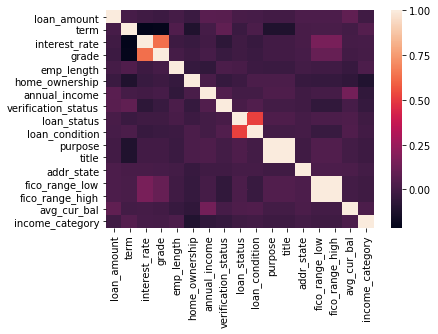

In [928]:
import seaborn as sns

sns.heatmap(corr_imp, 
        xticklabels=corr_imp.columns,
        yticklabels=corr_imp.columns)

# Data Preparation for Model Building

In [933]:
# Convert all non-numeric values to number
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
imp_columns=['loan_amount','term','interest_rate','grade','emp_length','home_ownership','annual_income','verification_status','loan_status','loan_condition','purpose','title','addr_state','fico_range_low','fico_range_high','avg_cur_bal','income_category']

for var in imp_columns:
    le = LabelEncoder()
    df[var]=le.fit_transform(df[var])
df[imp_columns].dtypes


loan_amount            int64
term                   int64
interest_rate          int64
grade                  int64
emp_length             int64
home_ownership         int64
annual_income          int64
verification_status    int64
loan_status            int64
loan_condition         int64
purpose                int64
title                  int64
addr_state             int64
fico_range_low         int64
fico_range_high        int64
avg_cur_bal            int64
income_category        int64
dtype: object

In [953]:
from sklearn import preprocessing
target_name='loan_condition'
y= df.loan_condition
y = y.isin(['Good Loan']).astype('int')
X= df[imp_columns].drop(target_name,axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

In [954]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [955]:
y_predict=knn.predict(X_test)
#y_predict=y_predict.reshape(-1,1)

In [956]:
knn.score(X_test,y_test)

1.0

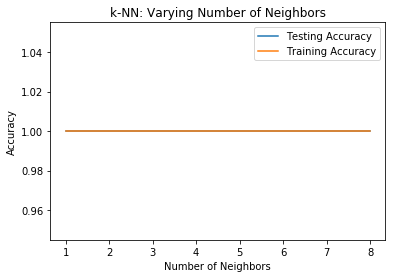

In [958]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
from sklearn.neighbors import KNeighborsClassifier
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# statsmodels works nicely with pandas dataframes
m = ols('loan_amount ~ interest_rate',df).fit()
print(m.summary())

In [ ]:
m1 = ols('loan_amount ~ verification_status',df).fit()
print(m1.summary())

In [ ]:
m = ols('loan_amount ~ fico_range_high',df).fit()
print(m.summary())

In [ ]:
df.select_dtypes('object').head()


In [771]:
df['bad_loans'] = (df['loan_condition'] == 'Bad Loan').apply(np.uint8)
df.drop('loan_condition', axis=1, inplace=True)

In [772]:
df.bad_loans.head()

0    0
1    0
2    1
3    0
4    0
Name: bad_loans, dtype: int64

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:



In [775]:
missing_fractions = df.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data


emp_title                0.156931
il_util                  0.146129
mths_since_recent_inq    0.119824
next_pymnt_d             0.107822
emp_length               0.080916
mo_sin_old_il_acct       0.031406
mths_since_rcnt_il       0.031406
num_tl_120dpd_2m         0.017403
bc_util                  0.013303
percent_bc_gt_75         0.013103
bc_open_to_buy           0.013103
mths_since_recent_bc     0.012503
dti                      0.001800
last_pymnt_d             0.001200
revol_util               0.000900
avg_cur_bal              0.000100
last_credit_pull_d       0.000100
all_util                 0.000100
dtype: float64


In [776]:
from sklearn.model_selection import train_test_split


In [777]:
y = df['bad_loans']
X= df.drop('bad_loans', axis=1)

In [778]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [783]:
X_train.head()

,id,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,emp_title,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,income_category,loan_condition_int
7234,145406500,2500,2500,2475,36,14.47,86.02,C,C2,NaN,...,0,0,35812,24520,4900,22312,N,N,Low,0
9232,145325134,5000,5000,5000,36,16.14,176.14,C,C4,NaN,...,1,0,4200,670,2200,0,N,N,Low,0
8169,145357528,12500,12500,12500,36,6.46,382.89,A,A1,Registered Nurse,...,0,0,288255,48854,14800,37855,N,N,Medium,0
6860,145350522,20000,20000,20000,60,8.81,413.33,A,A5,Engagement Support Lead,...,0,0,61800,21299,33700,0,N,N,Low,0
9407,145329467,10400,10400,10400,36,16.91,370.33,C,C5,Director of Adult Literacy,...,0,0,197742,180180,21200,176542,N,N,Low,0


# Model trainign and testing